# Data Preparation

In [1]:
#preamble
% matplotlib inline
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn import preprocessing as pp
from sklearn import linear_model as lm
from sklearn import feature_selection as fs
from sklearn import model_selection as ms
from sklearn import svm
from sklearn import metrics
from sklearn import naive_bayes as nb
from sklearn import neighbors as ne

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [2]:
#loading files to dataframe
nyse = pd.read_csv('~/Desktop/nyse/fundamentals.csv', parse_dates = ['Period Ending'])
prices = pd.read_csv('/Users/tomskehin/Desktop/nyse/prices-split-adjusted.csv', parse_dates = ['date'])

#Find limits for fundamentals period dates, must a price for the stock a year later for prediction
max_date = prices['date'].max() - dt.timedelta(days=365)
min_date = prices['date'].min()

#limiting fundamentals data to those dates
nyse = nyse[(nyse['Period Ending'] <= max_date)&(nyse['Period Ending'] >= min_date)]

nyse.reset_index(drop=True, inplace=True)

print("No. of samples:", nyse.shape[0])
print("No. of features:", nyse.shape[1])
print(nyse.columns.values)

No. of samples: 1556
No. of features: 79
['index' 'Ticker Symbol' 'Period Ending' 'Accounts Payable'
 'Accounts Receivable' "Add'l income/expense items" 'After Tax ROE'
 'Capital Expenditures' 'Capital Surplus' 'Cash Ratio'
 'Cash and Cash Equivalents' 'Changes in Inventories' 'Common Stocks'
 'Cost of Revenue' 'Current Ratio' 'Deferred Asset Charges'
 'Deferred Liability Charges' 'Depreciation'
 'Earnings Before Interest and Tax' 'Earnings Before Tax'
 'Effect of Exchange Rate' 'Equity Earnings/Loss Unconsolidated Subsidiary'
 'Fixed Assets' 'Goodwill' 'Gross Margin' 'Gross Profit' 'Income Tax'
 'Intangible Assets' 'Interest Expense' 'Inventory' 'Investments'
 'Liabilities' 'Long-Term Debt' 'Long-Term Investments' 'Minority Interest'
 'Misc. Stocks' 'Net Borrowings' 'Net Cash Flow' 'Net Cash Flow-Operating'
 'Net Cash Flows-Financing' 'Net Cash Flows-Investing' 'Net Income'
 'Net Income Adjustments' 'Net Income Applicable to Common Shareholders'
 'Net Income-Cont. Operations' 'Net Rec

In [3]:
#This loop finds the earliest business date after the 'Period Ending' date for
#which we have a price for each stock and earliest date for a price one year later
nsamples = len(nyse.index.values)

period_start = np.empty(nsamples,dtype=(str,10))
period_end = np.empty(nsamples,dtype=(str,10))

for i in nyse.index.values:

    ticker = nyse.loc[i]['Ticker Symbol']
    start = nyse.loc[i]['Period Ending']
    end = start + dt.timedelta(days=365)
        
    if i % 500==0: 
        
        print(i, 'rows processed')
    
    if prices[(prices['symbol']==ticker) & (prices['date']<=start + dt.timedelta(days=7))].shape[0]!=0 \
    and prices[(prices['symbol']==ticker) & (prices['date']<=end + dt.timedelta(days=7))].shape[0]!=0:
    
        #finding first date after 'Period Ending' date
        while prices[(prices['symbol']==ticker) & (prices['date']==start)].shape[0]==0:

            start += dt.timedelta(days=1)
        
        #finding first date one year later
        while prices[(prices['symbol']==ticker) & (prices['date']==end)].shape[0]==0:
            
            end += dt.timedelta(days=1)
            
        period_start[i] = start
        period_end[i] = end

print('----------------')
        
print(period_end.shape[0], 'end dates')
print(period_start.shape[0], 'start dates')


0 rows processed
500 rows processed
1000 rows processed
1500 rows processed
----------------
1556 end dates
1556 start dates


In [4]:
#Adding Start and End Date to the DataFrame
nyse['Start Date'] = pd.to_datetime(period_start)
nyse['End Date'] = pd.to_datetime(period_end)

#Joining Fundamental Dataframe and Equity Price Dataframe on Start and End Dates to get prices
nyse = pd.merge(nyse,prices,left_on=['Ticker Symbol','Start Date'],right_on=['symbol','date'],how='inner')
nyse = pd.merge(nyse,prices,left_on=['Ticker Symbol','End Date'],right_on=['symbol','date'],how='inner',
                suffixes=('_t0', '_t1'))

In [5]:
#Checking for Null Values
print('before')
print('----------------')
null_list = []

for column in list(nyse.columns):
    num_nulls = nyse[column].isnull().sum()
    if num_nulls != 0:
        print(column, ':', num_nulls, 'Nulls')
        null_list.append(column)

exception_list = ['For Year']

for column in list(nyse.columns):
    if not column in exception_list:
        num_nulls = nyse[column].isnull().sum()
        if num_nulls != 0:
            nyse = nyse.loc[nyse[column].notnull()]

print('\n')            
print('after')
print('----------------')
for column in null_list:
    num_nulls = nyse[column].isnull().sum()
    print(column, ':', num_nulls, 'Nulls')

before
----------------
Cash Ratio : 275 Nulls
Current Ratio : 275 Nulls
Quick Ratio : 275 Nulls
For Year : 51 Nulls
Earnings Per Share : 90 Nulls
Estimated Shares Outstanding : 90 Nulls


after
----------------
Cash Ratio : 0 Nulls
Current Ratio : 0 Nulls
Quick Ratio : 0 Nulls
For Year : 0 Nulls
Earnings Per Share : 0 Nulls
Estimated Shares Outstanding : 0 Nulls


In [6]:
#Book Value
nyse['Book Value'] = nyse['Total Assets'] - nyse['Intangible Assets'] - nyse['Total Liabilities']

#Asset Turnover
nyse['Asset Turnover'] = nyse['Total Revenue'] / nyse['Total Assets'] 

#Equity Turnover
nyse['Equity Turnover'] = nyse['Total Revenue'] / nyse['Total Equity'] 

#Financial Leverage
nyse['Financial Leverage'] = nyse['Operating Income'] / nyse['Net Income']

#P/E Ratio
nyse['P/E Ratio'] = nyse['close_t0'] / nyse['Earnings Per Share']

#P/B Ratio
nyse['P/B Ratio'] = nyse['Book Value']

#P/CF Ratio
nyse['P/CF Ratio'] = (nyse['close_t0'] * nyse['Estimated Shares Outstanding']) / nyse['Net Cash Flow']

#Calculating Percentage Equity Price Change over Period
nyse['Percentage Change'] = (nyse['close_t1'] / nyse['close_t0']) - 1 

#Creating Target Feature, identifying those equities with at least a 10% increase in price
nyse['Target']= nyse['Percentage Change'].apply(lambda x: 1 if x >= 0.10 else 0)


In [7]:
#removing infinite values
print ('before:')
print('----------------')
for column in list(nyse.columns[-9:]):
    num_infs = nyse[nyse[column] == np.inf].shape[0]
    print(column, ':', num_infs, 'Infs') 
    
for column in list(nyse.columns[-9:]):
    num_infs = nyse[nyse[column] == np.inf].shape[0]
    nyse = nyse[nyse[column] != np.inf]

print('\n')  
print ('after:')
print('----------------')
for column in list(nyse.columns[-9:]):
    num_infs = nyse[nyse[column] == np.inf].shape[0]
    print(column, ':', num_infs, 'Infs') 

before:
----------------
Book Value : 0 Infs
Asset Turnover : 0 Infs
Equity Turnover : 0 Infs
Financial Leverage : 0 Infs
P/E Ratio : 0 Infs
P/B Ratio : 0 Infs
P/CF Ratio : 2 Infs
Percentage Change : 0 Infs
Target : 0 Infs


after:
----------------
Book Value : 0 Infs
Asset Turnover : 0 Infs
Equity Turnover : 0 Infs
Financial Leverage : 0 Infs
P/E Ratio : 0 Infs
P/B Ratio : 0 Infs
P/CF Ratio : 0 Infs
Percentage Change : 0 Infs
Target : 0 Infs


# Feature Selection

In [8]:
nyse_feature_name = [
 'Cash Ratio'
,'Cash and Cash Equivalents'
,'Current Ratio'
,'Fixed Assets'
,'Gross Profit'
,'Intangible Assets'
,'Long-Term Debt'
,'Long-Term Investments'
,'Net Cash Flow'
,'Net Cash Flow-Operating'
,'Net Cash Flows-Financing'
,'Net Cash Flows-Investing'
,'Net Income'
,'Profit Margin'
,'Quick Ratio'
,'Total Assets'
,'Total Equity'
,'Total Liabilities'
,'Total Revenue'
,'Earnings Per Share'
,'Depreciation'
,'Inventory'
,'Investments'
,'Operating Margin'
,'Research and Development'
,'Retained Earnings'
,'Book Value'
,'Asset Turnover'
,'Equity Turnover'
,'Financial Leverage'
,'P/E Ratio'
,'P/B Ratio'
,'P/CF Ratio'       
]

In [9]:
nyse_feature = nyse[nyse_feature_name].as_matrix()
nyse_target = nyse['Target'].as_matrix()

nyse[nyse_feature_name].to_csv('~/Desktop/nyse/nyse_feature.csv')
nyse['Target'].to_csv('~/Desktop/nyse/nyse_target.csv')

print('No. of Samples:', nyse_feature.shape[0])
print('No. of Features:', nyse_feature.shape[1])

No. of Samples: 1185
No. of Features: 33


# Experiment 1

In [10]:
#Scaling Feature values between 0 and 1 
scaler = pp.MinMaxScaler(feature_range=(0, 1))
nyse_feature_standard = scaler.fit_transform(nyse_feature)

#train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_standard, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))


model = svm.SVC(probability=True, kernel='linear')
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.45      0.18      0.25        51
          1       0.58      0.84      0.68        68

avg / total       0.52      0.55      0.50       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.33      0.04      0.07        51
          1       0.57      0.94      0.71        68

avg / total       0.47      0.55      0.43       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.50      0.16      0.24        51
          1       0.58      0.88      0.70        68

avg / total       0.55      0.57      0.50       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.38      0.35      0.37        51
          1       0.54      0.57      0.56        68

avg / total       0.47      0.48      0.48       119



# Experiment 2

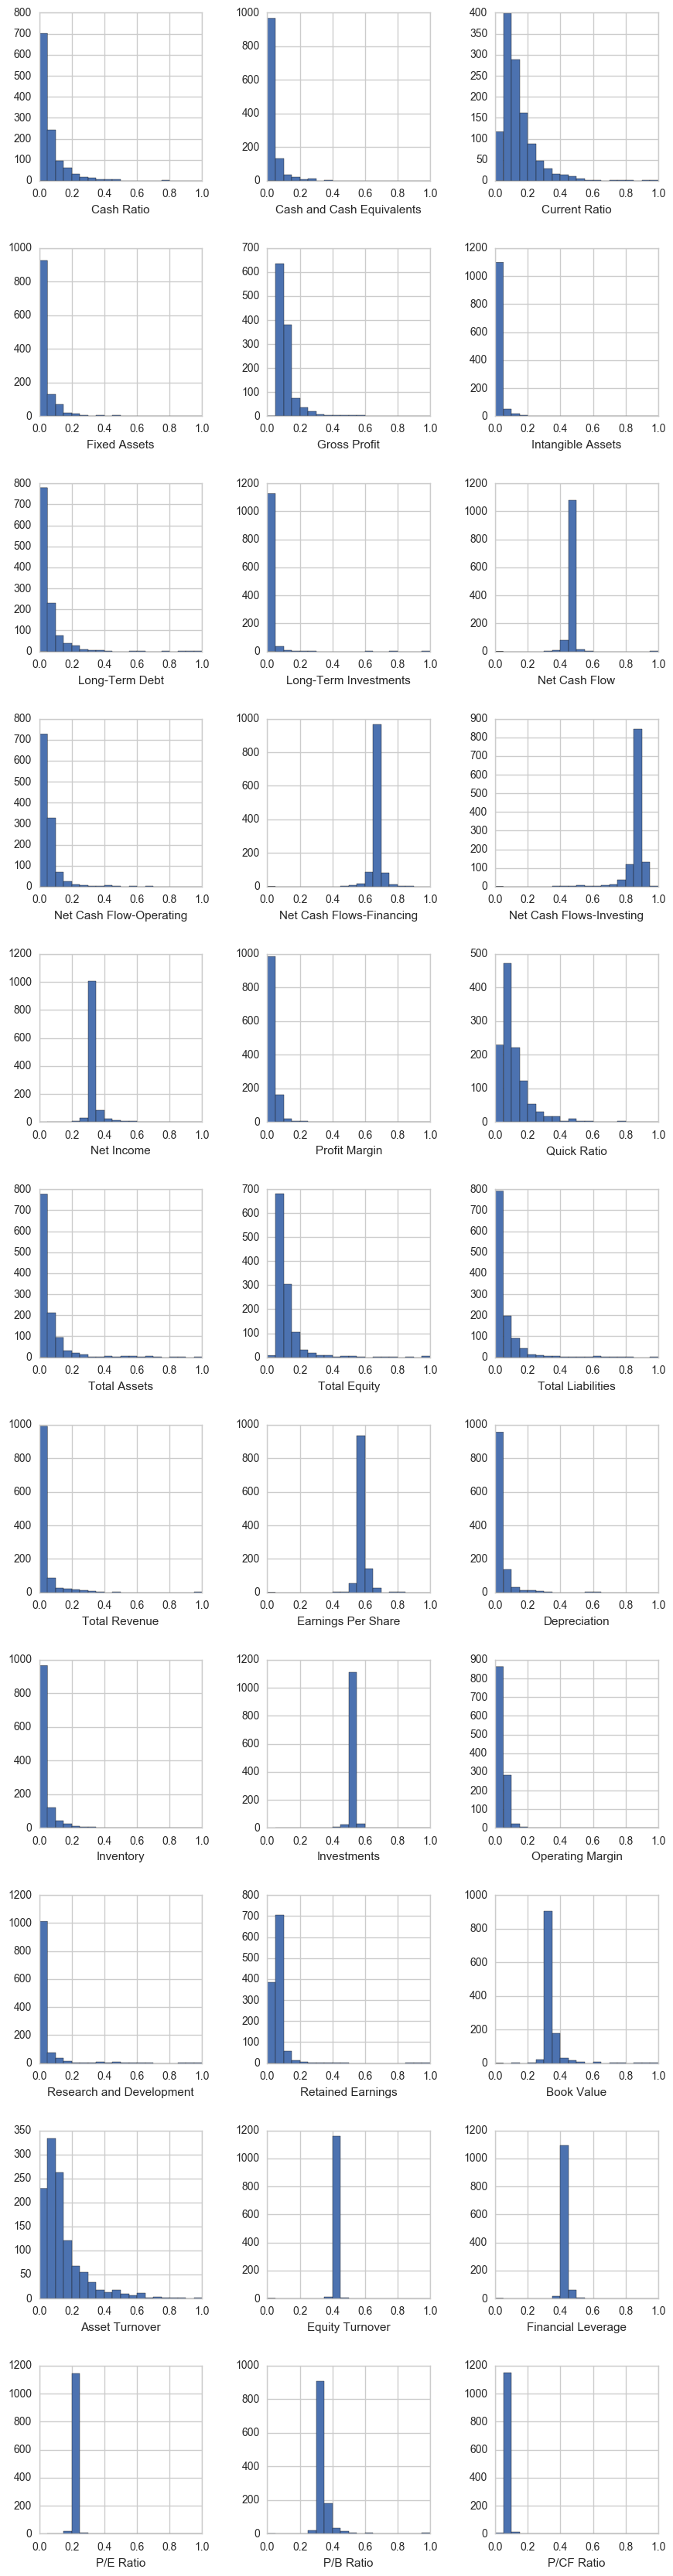

In [15]:
fig = plt.figure(figsize=(8,60))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
for i in range(len(nyse_feature_name)):
    ax = fig.add_subplot(20, 3, i+1,xlabel=nyse_feature_name[i])
    ax.hist(nyse_feature_standard[:, i], bins=20)
plt.show()

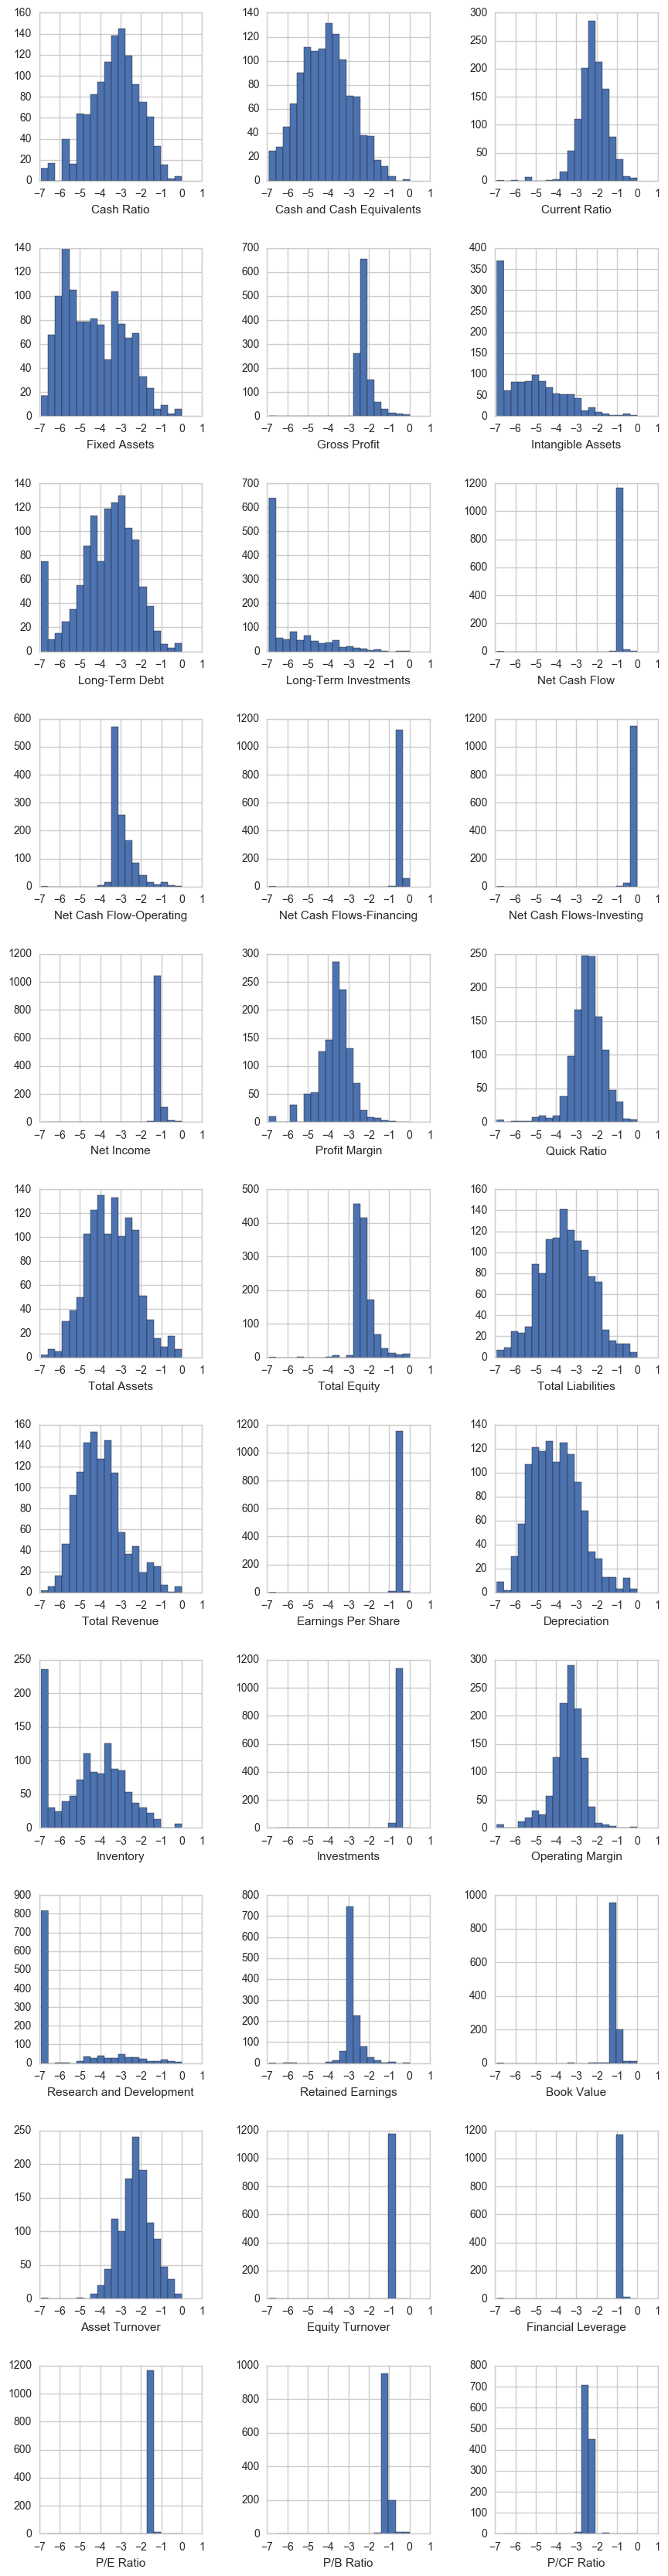

In [59]:
nyse_feature_standard_log = np.log(nyse_feature_standard + 0.001)

fig = plt.figure(figsize=(8,60))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
for i in range(len(nyse_feature_name)):
    ax = fig.add_subplot(20, 3, i+1,xlabel=nyse_feature_name[i])
    ax.hist(nyse_feature_standard_log[:, i], bins=20)
plt.show()

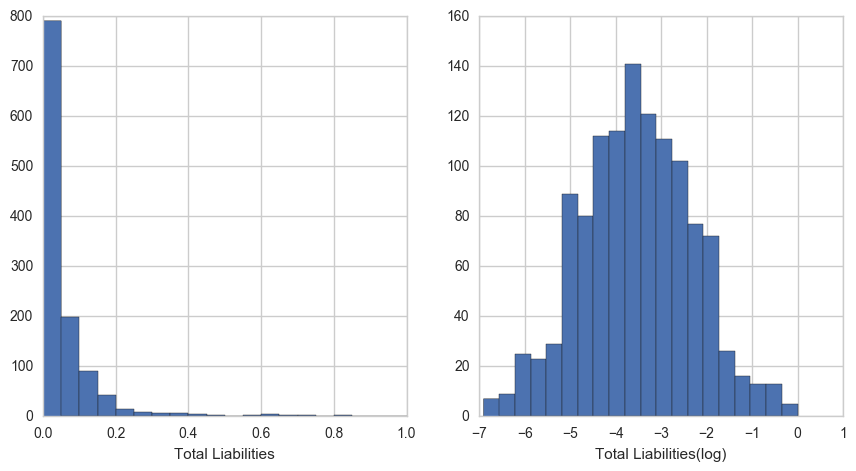

In [61]:
index = nyse_feature_name.index('Total Liabilities')

fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.2)

ax1 = fig.add_subplot(1, 2, 1,xlabel=nyse_feature_name[index])
ax1.hist(nyse_feature_standard[:, index], bins=20)

ax2 = fig.add_subplot(1, 2, 2,xlabel=nyse_feature_name[index] + '(log)')
ax2.hist(nyse_feature_standard_log[:, index], bins=20)

plt.show()

fig.savefig('/Users/tomskehin/Desktop/test.png')

In [62]:
## Scaling Feature values between 0 and 1 
scaler = pp.MinMaxScaler(feature_range=(0, 1))
nyse_feature_standard_log = scaler.fit_transform(nyse_feature_standard_log)

#train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_standard_log, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))


model = svm.SVC(probability=True, kernel='linear')
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.50      0.39      0.44        51
          1       0.61      0.71      0.65        68

avg / total       0.56      0.57      0.56       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.52      0.24      0.32        51
          1       0.59      0.84      0.70        68

avg / total       0.56      0.58      0.54       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.45      0.10      0.16        51
          1       0.57      0.91      0.70        68

avg / total       0.52      0.56      0.47       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.47      0.43      0.45        51
          1       0.60      0.63      0.61        68

avg / total       0.54      0.55      0.54       119



# Experiment 3

In [63]:
#Testing the standard features again the log features to see which is the more likel;y to be normally distributed
for i in range(len(nyse_feature_name)):
    arr = nyse_feature_standard[:,i]
    arr_log = nyse_feature_standard_log[:,i]
    print(nyse_feature_name[i], stats.normaltest(arr)[1] >= stats.normaltest(arr_log)[1])

Cash Ratio False
Cash and Cash Equivalents False
Current Ratio False
Fixed Assets False
Gross Profit False
Intangible Assets False
Long-Term Debt False
Long-Term Investments False
Net Cash Flow True
Net Cash Flow-Operating False
Net Cash Flows-Financing True
Net Cash Flows-Investing True
Net Income True
Profit Margin False
Quick Ratio False
Total Assets False
Total Equity False
Total Liabilities False
Total Revenue False
Earnings Per Share True
Depreciation False
Inventory False
Investments True
Operating Margin False
Research and Development False
Retained Earnings False
Book Value True
Asset Turnover False
Equity Turnover True
Financial Leverage True
P/E Ratio True
P/B Ratio True
P/CF Ratio False


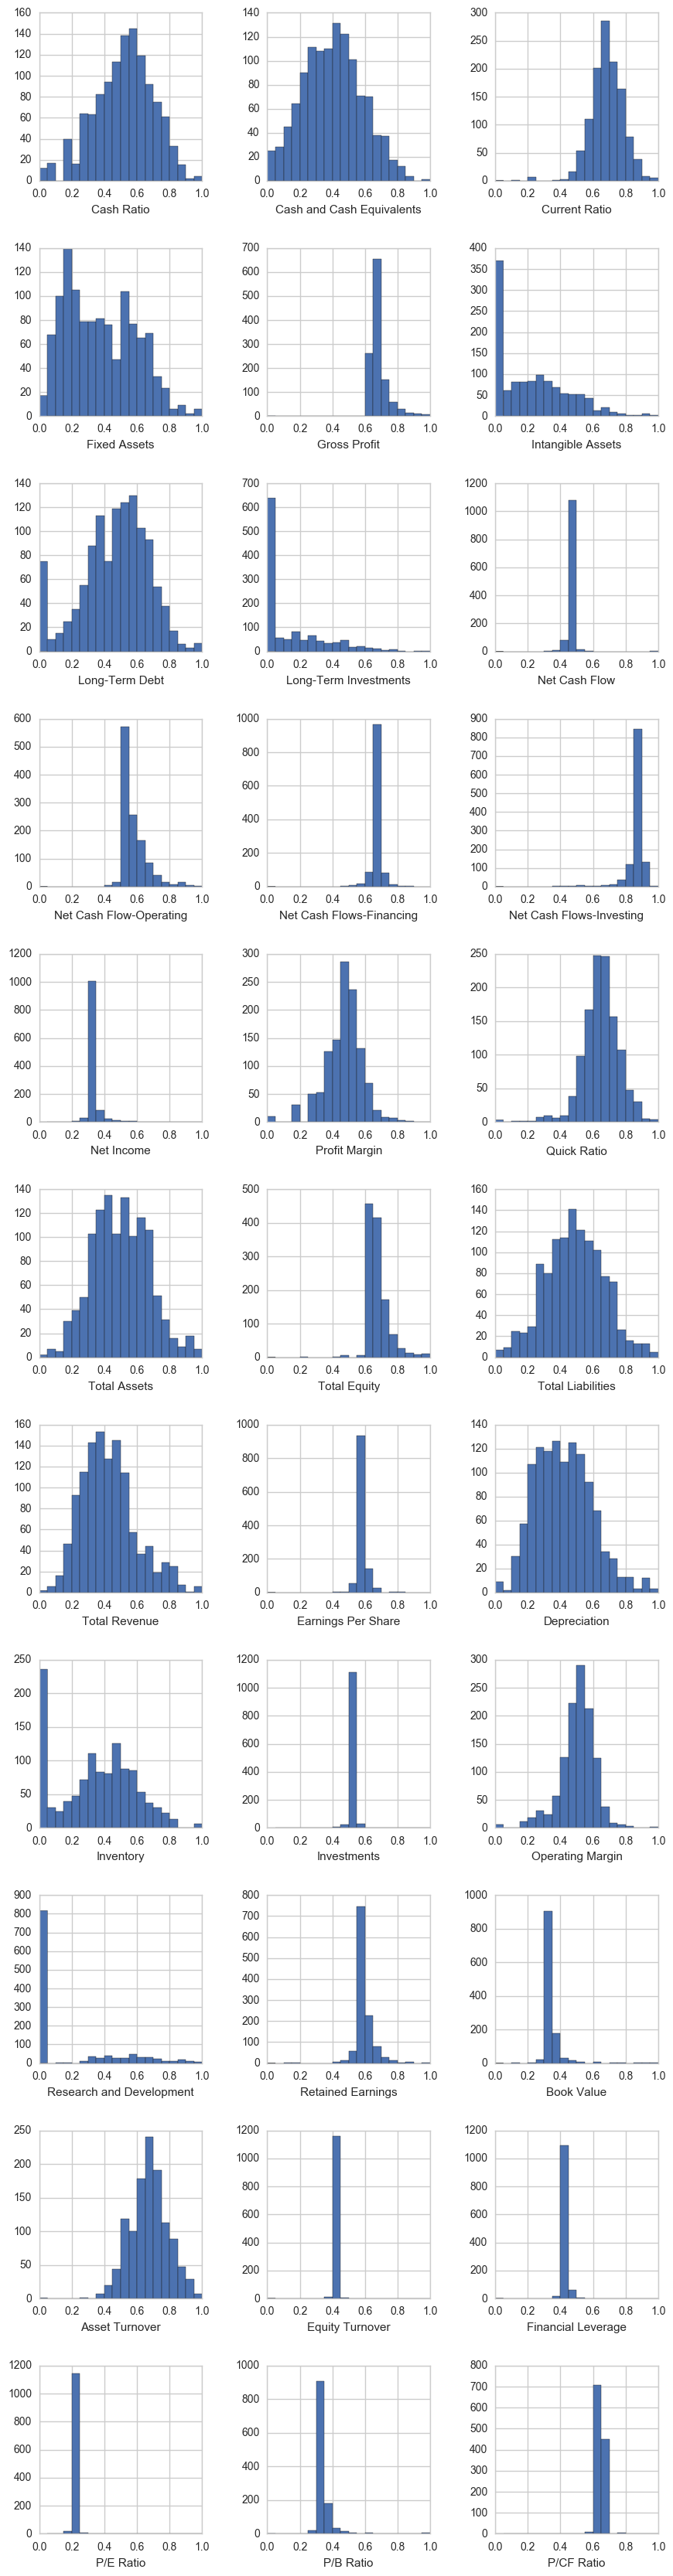

In [64]:
#creating a hybrid matrix of features where the 'more normally distributed' between standard and log is selected
normal = []

for i in range(len(nyse_feature_name)):

    arr = nyse_feature_standard[:,i]
    arr_log = nyse_feature_standard_log[:,i]
    
    if stats.normaltest(arr)[1] >= stats.normaltest(arr_log)[1]:
        normal.append(arr)
    else:
        normal.append(arr_log)
        
nyse_feature_hybrid = np.column_stack(normal)

fig = plt.figure(figsize=(8,60))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
for i in range(len(nyse_feature_name)):
    x = nyse_feature[:, i]
    ax = fig.add_subplot(20, 3, i+1,xlabel=nyse_feature_name[i])
    ax.hist(nyse_feature_hybrid[:, i], bins=20)
plt.show()

In [65]:
#train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))


model = svm.SVC(probability=True, kernel='linear')
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.49      0.37      0.42        51
          1       0.60      0.71      0.65        68

avg / total       0.55      0.56      0.55       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.46      0.22      0.29        51
          1       0.58      0.81      0.67        68

avg / total       0.53      0.55      0.51       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.53      0.20      0.29        51
          1       0.59      0.87      0.70        68

avg / total       0.56      0.58      0.52       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.44      0.43      0.44        51
          1       0.58      0.59      0.58        68

avg / total       0.52      0.52      0.52       119



# Experiment 4

In [75]:
#Scaling Feature values between 0 and 1 
scaler = pp.RobustScaler()
nyse_feature_hybrid_standard = scaler.fit_transform(nyse_feature_hybrid)

#train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid_standard, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))


model = svm.SVC(probability=True, kernel='linear', cache_size = 1000) #linear’ ‘poly’ ‘rbf’ ‘sigmoid’
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

print('Coefficients')
print('-------------------')
for i in range(len(nyse_feature_name_new)):
    print(nyse_feature_name_new[i],':',model.coef_[:,i])

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))


Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.44      0.45      0.45        51
          1       0.58      0.57      0.58        68

avg / total       0.52      0.52      0.52       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.62      0.39      0.48        51
          1       0.64      0.82      0.72        68

avg / total       0.64      0.64      0.62       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.53      0.20      0.29        51
          1       0.59      0.87      0.70        68

avg / total       0.56      0.58      0.52       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.51      0.63      0.56        51
          1       0.66      0.54      0.60        68

avg / total       0.60      0.58      0.58       119



# Experiment 5

In [76]:
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid_standard, nyse_target, test_size=0.1, random_state=0)

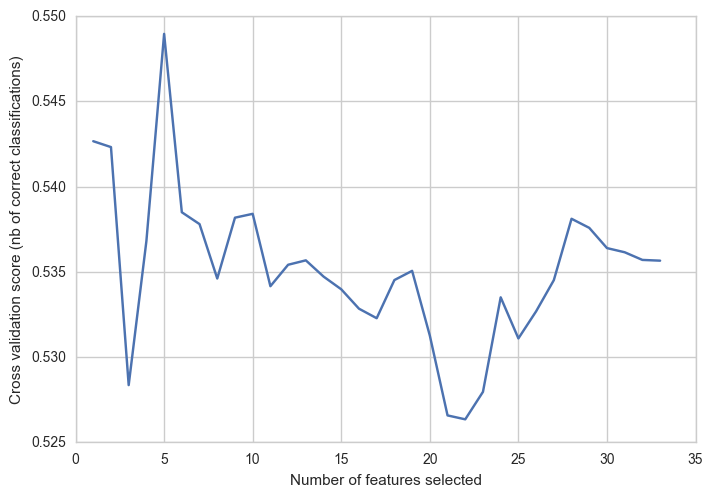

Logistic Regression
No. included features: 5
No. excluded features: 28
-------------------
             precision    recall  f1-score   support

          0       0.52      0.45      0.48        51
          1       0.63      0.69      0.66        68

avg / total       0.58      0.59      0.58       119



In [78]:
model = lm.LogisticRegression()
rfecv = fs.RFECV(estimator=model, cv=10, scoring='roc_auc')

nyse_feature_train_rfe = rfecv.fit_transform(nyse_feature_train,nyse_target_train)

nyse_feature_name_new = [nyse_feature_name[i] for i in rfecv.get_support(indices=True)]
nyse_feature_name_excluded = list(set(nyse_feature_name) - set(nyse_feature_name_new))

model.fit(nyse_feature_train_rfe, nyse_target_train)
nyse_feature_test_rfe = rfecv.transform(nyse_feature_test)

predicted = model.predict(nyse_feature_test_rfe)
probs = model.predict_proba(nyse_feature_test_rfe)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# generate evaluation metrics
print('Logistic Regression')
print('No. included features:', len(nyse_feature_name_new))
print('No. excluded features:', len(nyse_feature_name_excluded))   
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))


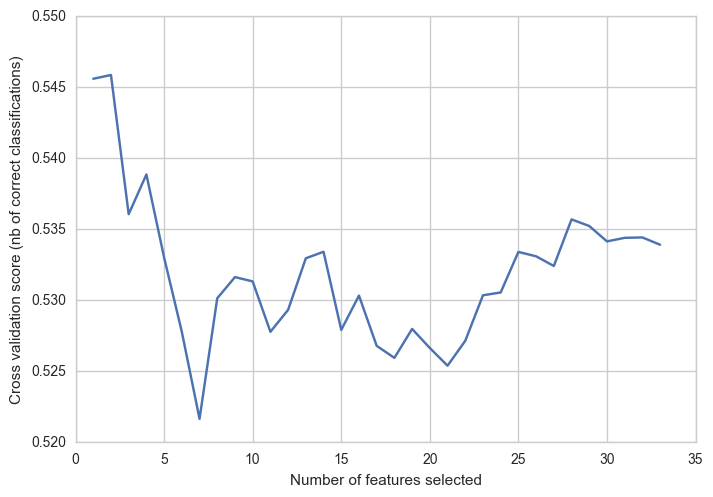

SVM
No. included features: 2
No. excluded features: 31
-------------------
             precision    recall  f1-score   support

          0       0.40      0.12      0.18        51
          1       0.57      0.87      0.69        68

avg / total       0.50      0.55      0.47       119



In [79]:
model = svm.SVC(probability=True, kernel='linear')
rfecv = fs.RFECV(estimator=model, cv=10, scoring='roc_auc')

nyse_feature_train_rfe = rfecv.fit_transform(nyse_feature_train,nyse_target_train)

nyse_feature_name_new = [nyse_feature_name[i] for i in rfecv.get_support(indices=True)]
nyse_feature_name_excluded = list(set(nyse_feature_name) - set(nyse_feature_name_new))

model.fit(nyse_feature_train_rfe, nyse_target_train)
nyse_feature_test_rfe = rfecv.transform(nyse_feature_test)

predicted = model.predict(nyse_feature_test_rfe)
probs = model.predict_proba(nyse_feature_test_rfe)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# generate evaluation metrics
print('SVM')
print('No. included features:', len(nyse_feature_name_new))
print('No. excluded features:', len(nyse_feature_name_excluded)) 
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

# Experiment 6

Highest Accuracy: 0.563800721017
Best k: 57


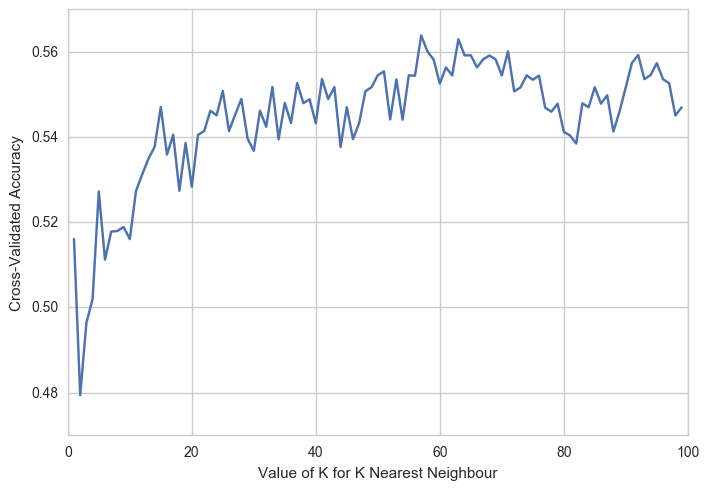

In [80]:
k_range = list(range(1, 100))
k_scores = []

for k in k_range:
    knn = ne.KNeighborsClassifier(n_neighbors=k)
    scores = ms.cross_val_score(knn, nyse_feature_train, nyse_target_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for K Nearest Neighbour')
plt.ylabel('Cross-Validated Accuracy')

print('Highest Accuracy:', max(k_scores))

k_index = k_scores.index(max(k_scores))
best_k = k_range[k_index]

print('Best k:', best_k)

In [81]:
model = ne.KNeighborsClassifier(n_neighbors=57)
 
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

# generate evaluation metrics
print('Accuracy Score:', metrics.accuracy_score(nyse_target_test, predicted,))
print('ROC Score:', metrics.roc_auc_score(nyse_target_test, probs[:, 1]),'\n')
print('Confusion Matrix: \n', metrics.confusion_matrix(nyse_target_test, predicted))
print('Classification Report: \n', metrics.classification_report(nyse_target_test, predicted))

Accuracy Score: 0.579831932773
ROC Score: 0.605103806228 

Confusion Matrix: 
 [[23 28]
 [22 46]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.51      0.45      0.48        51
          1       0.62      0.68      0.65        68

avg / total       0.57      0.58      0.58       119



In [86]:
#train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid_standard, nyse_target, test_size=0.1, random_state=0)

model = svm.SVC(probability=True, kernel='linear', cache_size = 1000) #linear’ ‘poly’ ‘rbf’ ‘sigmoid’
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

print('Coefficients')
print('-------------------')
for i in range(len(nyse_feature_name)):
    print(nyse_feature_name[i],':',model.coef_[:,i])

SVM
-------------------
             precision    recall  f1-score   support

          0       0.62      0.39      0.48        51
          1       0.64      0.82      0.72        68

avg / total       0.64      0.64      0.62       119

Coefficients
-------------------
Cash Ratio : [ 0.55645818]
Cash and Cash Equivalents : [-0.45622656]
Current Ratio : [-0.38299485]
Fixed Assets : [ 0.2687416]
Gross Profit : [ 0.01399339]
Intangible Assets : [ 0.01640458]
Long-Term Debt : [ 0.2472834]
Long-Term Investments : [ 0.13308045]
Net Cash Flow : [ 0.04467729]
Net Cash Flow-Operating : [-0.79191085]
Net Cash Flows-Financing : [-0.12740273]
Net Cash Flows-Investing : [-0.20872689]
Net Income : [-0.12628924]
Profit Margin : [-0.08940737]
Quick Ratio : [-0.14378737]
Total Assets : [ 0.62860721]
Total Equity : [ 0.0141012]
Total Liabilities : [-0.55298234]
Total Revenue : [-0.2136378]
Earnings Per Share : [-0.02831594]
Depreciation : [-0.39255485]
Inventory : [ 0.36906754]
Investments : [ 0.00034

# Intuitive Model

In [97]:
nyse_feature_name_final = [
'Cash Ratio'
,'Cash and Cash Equivalents'
,'Current Ratio'
,'Fixed Assets'
,'Long-Term Debt'
,'Net Cash Flow-Operating'
,'Net Cash Flows-Investing'
,'Total Assets'
,'Total Liabilities'
,'Total Revenue'
,'Depreciation'
,'Inventory'
,'Research and Development'
,'Asset Turnover'
]

final = []



for feature in nyse_feature_name_final:

    i = nyse_feature_name.index(feature)
    arr = nyse_feature_hybrid_standard[:,i]
    final.append(arr)
       
nyse_feature_final = np.column_stack(final)

print(nyse_feature_final.shape)

(1185, 14)


In [99]:
#train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_final, nyse_target, test_size=0.1, random_state=0)

model = svm.SVC(probability=True, kernel='linear', cache_size = 1000) #linear’ ‘poly’ ‘rbf’ ‘sigmoid’
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

print('Coefficients')
print('-------------------')
for i in range(len(nyse_feature_name_final)):
    print(nyse_feature_name_final[i],':',model.coef_[:,i])

SVM
-------------------
             precision    recall  f1-score   support

          0       0.54      0.29      0.38        51
          1       0.60      0.81      0.69        68

avg / total       0.57      0.59      0.56       119

Coefficients
-------------------
Cash Ratio : [ 0.34792491]
Cash and Cash Equivalents : [-0.37053584]
Current Ratio : [-0.37119593]
Fixed Assets : [ 0.30155475]
Long-Term Debt : [ 0.20471455]
Net Cash Flow-Operating : [-0.64476543]
Net Cash Flows-Investing : [-0.06463443]
Total Assets : [ 0.68700583]
Total Liabilities : [-0.45089202]
Total Revenue : [-0.44060576]
Depreciation : [-0.18849734]
Inventory : [ 0.34591923]
Research and Development : [ 0.24243051]
Asset Turnover : [ 0.37874116]
